In [2]:
# Initial Pandas and matplotlib import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openpyxl as xl
from datetime import datetime
import ast
from adjustText import adjust_text
from datasets import load_dataset
import seaborn as sns

/opt/anaconda3/envs/LBCourseEnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load in jobs dataset as dataframe
dataset = load_dataset('lukebarousse/data_jobs')
jobs_data = dataset['train'].to_pandas()

Generating train split: 100%|██████████| 785741/785741 [00:03<00:00, 215368.74 examples/s]


In [4]:
# Convert job_posted_date to datetime type, convert nested job skill list strings to lists, and output field info
jobs_data['job_posted_date'] = pd.to_datetime(jobs_data['job_posted_date'])
jobs_data['job_skills'] = jobs_data['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
jobs_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785741 entries, 0 to 785740
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   job_title_short        785741 non-null  object        
 1   job_title              785740 non-null  object        
 2   job_location           784696 non-null  object        
 3   job_via                785733 non-null  object        
 4   job_schedule_type      773074 non-null  object        
 5   job_work_from_home     785741 non-null  bool          
 6   search_location        785741 non-null  object        
 7   job_posted_date        785741 non-null  datetime64[ns]
 8   job_no_degree_mention  785741 non-null  bool          
 9   job_health_insurance   785741 non-null  bool          
 10  job_country            785692 non-null  object        
 11  salary_rate            33067 non-null   object        
 12  salary_year_avg        22003 non-null   floa

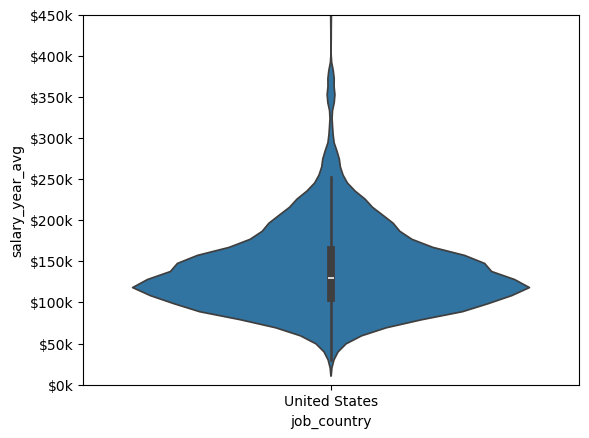

In [319]:
# Create a violin plot using Seaborn to visualize the distribution of salary_year_avg 
# for Data Scientist roles in the United States.

sns.violinplot(us_ds_jobs, x = 'job_country', y = 'salary_year_avg')
plt.ylim(0, 450000)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'${int(x/1000)}k'))
